## A/B Testing
### Task statement
You've received an analytical task from an international online store. Your predecessor failed to complete it: they launched an A/B test and then quit (to start a watermelon farm in Brazil). They left only the technical specifications and the test results.

### Technical description

- Test name: `recommender_system_test`
- Groups: А (control), B (new payment funnel)
- Launch date: 2020-12-07
- The date when they stopped taking up new users: 2020-12-21
- End date: 2021-01-01
- Audience: 15% of the new users from the EU region
- Purpose of the test: testing changes related to the introduction of an improved recommendation system
- Expected result: within 14 days of signing up, users will show better conversion into product page views (the `product_page` event), product card views (`product_card`) and purchases (`purchase`). At each of the stage of the funnel `product_page → product_card → purchase`, there will be at least a 10% increase.

### Data description
- `ab_project_marketing_events_us.csv` — the calendar of marketing events for 2020
- `final_ab_new_users_upd_us.csv` — all users who signed up in the online store from December 7 to 21, 2020
- `final_ab_events_upd_us.csv` — all events of the new users within the period from December 7, 2020 to January 1, 2021
- `final_ab_participants_upd_us.csv` — table containing test participants

### Goal 
- Complete the test and evaluate the results of it.

#### Load libraries

In [49]:
import pandas as pd  
import numpy as np
import datetime
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set(style="darkgrid")
from termcolor import colored
from functools import reduce
from scipy import stats as st
import math as mth
from plotly import graph_objects as go

#### Import and look in the data

In [2]:
try:
    ab_project_marketing_events_us = pd.read_csv('ab_project_marketing_events_us.csv',\
                                             dtype={'name':'category','regions':'category'},\
                                             parse_dates=['start_dt','finish_dt'])
    final_ab_new_users_upd_us = pd.read_csv('final_ab_new_users_upd_us.csv',\
                                        dtype={'device':'category','region':'category'},\
                                        parse_dates=['first_date'])
except:
    ab_project_marketing_events_us = pd.read_csv('/datasets/ab_project_marketing_events_us.csv',\
                                             dtype={'name':'category','regions':'category'},\
                                             parse_dates=['start_dt','finish_dt'])
    final_ab_new_users_upd_us = pd.read_csv('/datasets/final_ab_new_users_upd_us.csv',\
                                        dtype={'device':'category','region':'category'},\
                                        parse_dates=['first_date'])
    

In [3]:
ab_project_marketing_events_us.head()

,Unnamed: 0,name,regions,start_dt,finish_dt
0,0,Christmas&New Year Promo,"EU, N.America",2020-12-25,2021-01-03
1,1,St. Valentine's Day Giveaway,"EU, CIS, APAC, N.America",2020-02-14,2020-02-16
2,2,St. Patric's Day Promo,"EU, N.America",2020-03-17,2020-03-19
3,3,Easter Promo,"EU, CIS, APAC, N.America",2020-04-12,2020-04-19
4,4,4th of July Promo,N.America,2020-07-04,2020-07-11


In [4]:
ab_project_marketing_events_us = pd.read_csv('ab_project_marketing_events_us.csv',\
                                             dtype={'name':'category','regions':'category'},\
                                             parse_dates=['start_dt','finish_dt'])
final_ab_new_users_upd_us = pd.read_csv('final_ab_new_users_upd_us.csv',\
                                        dtype={'device':'category','region':'category'},\
                                        parse_dates=['first_date'])
final_ab_events_upd_us = pd.read_csv('final_ab_events_upd_us.csv')
final_ab_participants_upd_us = pd.read_csv('final_ab_participants_upd_us.csv')

* We transformed the datetime variables and convert the objects to categorical attributes by the import of the data

In [5]:
ab_project_marketing_events_us.drop('Unnamed: 0',axis=1,inplace=True)
display(ab_project_marketing_events_us.info())
display(ab_project_marketing_events_us.describe(include='all'))
ab_project_marketing_events_us.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14 entries, 0 to 13
Data columns (total 4 columns):
name         14 non-null category
regions      14 non-null category
start_dt     14 non-null datetime64[ns]
finish_dt    14 non-null datetime64[ns]
dtypes: category(2), datetime64[ns](2)
memory usage: 1.3 KB


None

,name,regions,start_dt,finish_dt
count,14,14,14,14
unique,14,6,14,14
top,Victory Day CIS (May 9th) Event,APAC,2020-02-14 00:00:00,2020-05-11 00:00:00
freq,1,4,1,1
first,NaN,NaN,2020-01-25 00:00:00,2020-02-07 00:00:00
last,NaN,NaN,2020-12-30 00:00:00,2021-01-07 00:00:00


,name,regions,start_dt,finish_dt
0,Christmas&New Year Promo,"EU, N.America",2020-12-25,2021-01-03
1,St. Valentine's Day Giveaway,"EU, CIS, APAC, N.America",2020-02-14,2020-02-16
2,St. Patric's Day Promo,"EU, N.America",2020-03-17,2020-03-19
3,Easter Promo,"EU, CIS, APAC, N.America",2020-04-12,2020-04-19
4,4th of July Promo,N.America,2020-07-04,2020-07-11


* We have 14 different marketing events with the first one to have lunched on 2020-01-25 and end on 2020-02-07.


In [6]:
final_ab_new_users_upd_us.drop('Unnamed: 0',axis=1,inplace=True)
display(final_ab_new_users_upd_us.head())
display(final_ab_new_users_upd_us.info())
display(final_ab_new_users_upd_us.describe(include='all'))

,user_id,first_date,region,device
0,D72A72121175D8BE,2020-12-07,EU,PC
1,F1C668619DFE6E65,2020-12-07,N.America,Android
2,2E1BF1D4C37EA01F,2020-12-07,EU,PC
3,50734A22C0C63768,2020-12-07,EU,iPhone
4,E1BDDCE0DAFA2679,2020-12-07,N.America,iPhone


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 58703 entries, 0 to 58702
Data columns (total 4 columns):
user_id       58703 non-null object
first_date    58703 non-null datetime64[ns]
region        58703 non-null category
device        58703 non-null category
dtypes: category(2), datetime64[ns](1), object(1)
memory usage: 1.0+ MB


None

,user_id,first_date,region,device
count,58703,58703,58703,58703
unique,58703,17,4,4
top,DFAC77278F1CFBFD,2020-12-21 00:00:00,EU,Android
freq,1,6077,43396,26159
first,NaN,2020-12-07 00:00:00,NaN,NaN
last,NaN,2020-12-23 00:00:00,NaN,NaN


* it Would be convenient to change the name column first_date to sign_date

In [7]:
final_ab_new_users_upd_us['region'].value_counts()

EU           43396
N.America     9051
CIS           3130
APAC          3126
Name: region, dtype: int64

In [8]:
final_ab_events_upd_us.drop('Unnamed: 0',axis=1,inplace=True)
display(final_ab_events_upd_us.head())
display(final_ab_events_upd_us.info())
display(final_ab_events_upd_us.describe(include='all'))

,user_id,event_dt,event_name,details
0,E1BDDCE0DAFA2679,2020-12-07 20:22:03,purchase,99.99
1,7B6452F081F49504,2020-12-07 09:22:53,purchase,9.99
2,9CD9F34546DF254C,2020-12-07 12:59:29,purchase,4.99
3,96F27A054B191457,2020-12-07 04:02:40,purchase,4.99
4,1FD7660FDF94CA1F,2020-12-07 10:15:09,purchase,4.99


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 423761 entries, 0 to 423760
Data columns (total 4 columns):
user_id       423761 non-null object
event_dt      423761 non-null object
event_name    423761 non-null object
details       60314 non-null float64
dtypes: float64(1), object(3)
memory usage: 12.9+ MB


None

,user_id,event_dt,event_name,details
count,423761,423761,423761,60314.000000
unique,58703,257138,4,NaN
top,A3917F81482141F2,2020-12-14 18:54:55,login,NaN
freq,36,10,182465,NaN
mean,NaN,NaN,NaN,23.881219
std,NaN,NaN,NaN,72.228884
min,NaN,NaN,NaN,4.990000
25%,NaN,NaN,NaN,4.990000
50%,NaN,NaN,NaN,4.990000
75%,NaN,NaN,NaN,9.990000


In [9]:
final_ab_participants_upd_us.drop('Unnamed: 0',axis=1,inplace=True)
display(final_ab_participants_upd_us.head())
display(final_ab_participants_upd_us.info())
display(final_ab_participants_upd_us.describe(include='all'))

,user_id,group,ab_test
0,D1ABA3E2887B6A73,A,recommender_system_test
1,A7A3664BD6242119,A,recommender_system_test
2,DABC14FDDFADD29E,A,recommender_system_test
3,04988C5DF189632E,A,recommender_system_test
4,4FF2998A348C484F,A,recommender_system_test


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14525 entries, 0 to 14524
Data columns (total 3 columns):
user_id    14525 non-null object
group      14525 non-null object
ab_test    14525 non-null object
dtypes: object(3)
memory usage: 340.5+ KB


None

,user_id,group,ab_test
count,14525,14525,14525
unique,13638,2,2
top,412F5C9F04EE8F69,A,interface_eu_test
freq,2,8214,10850


In [10]:
display(ab_project_marketing_events_us.head(2))
display(final_ab_new_users_upd_us.head(2))
display(final_ab_events_upd_us.head(2))
display(final_ab_participants_upd_us.head(2))

,name,regions,start_dt,finish_dt
0,Christmas&New Year Promo,"EU, N.America",2020-12-25,2021-01-03
1,St. Valentine's Day Giveaway,"EU, CIS, APAC, N.America",2020-02-14,2020-02-16


,user_id,first_date,region,device
0,D72A72121175D8BE,2020-12-07,EU,PC
1,F1C668619DFE6E65,2020-12-07,N.America,Android


,user_id,event_dt,event_name,details
0,E1BDDCE0DAFA2679,2020-12-07 20:22:03,purchase,99.99
1,7B6452F081F49504,2020-12-07 09:22:53,purchase,9.99


,user_id,group,ab_test
0,D1ABA3E2887B6A73,A,recommender_system_test
1,A7A3664BD6242119,A,recommender_system_test


### Data preprocessing


In [11]:
datasets=[ab_project_marketing_events_us,final_ab_new_users_upd_us,\
          final_ab_events_upd_us,final_ab_participants_upd_us]
for i in datasets:
    print(i.isnull().sum())
    print('\n')

name         0
regions      0
start_dt     0
finish_dt    0
dtype: int64


user_id       0
first_date    0
region        0
device        0
dtype: int64


user_id            0
event_dt           0
event_name         0
details       363447
dtype: int64


user_id    0
group      0
ab_test    0
dtype: int64




* We have 363.447 missing values in the 'details' column in the final_ab_events_upd_us dataframe, and that is related to the users who didn't end up to a purchase
* We will not fill them cause they will help us to analyse the user's behaviour and fetch info.

In [12]:
print(final_ab_events_upd_us.duplicated().sum())
print(final_ab_new_users_upd_us.duplicated().sum())
print(final_ab_events_upd_us.duplicated().sum())
print(final_ab_participants_upd_us.duplicated().sum())

0
0
0
0


* There are not any duplicates

In [13]:
#change the column name date of the sign up of the final_ab_new_users_upd_us table
final_ab_new_users_upd_us['sign_date']=final_ab_new_users_upd_us['first_date']
final_ab_new_users_upd_us.drop('first_date',axis=1,inplace=True)

In [14]:
#take the date from the datetime attribute
final_ab_events_upd_us['event_dt_date']=final_ab_events_upd_us['event_dt'].astype('datetime64[D]')

In [15]:
#merge the tables 
final_recommender=reduce(lambda left,right: left.merge(right,on='user_id',how='left')\
                           ,[final_ab_participants_upd_us,final_ab_new_users_upd_us,final_ab_events_upd_us])
final_recommender.head()

,user_id,group,ab_test,region,device,sign_date,event_dt,event_name,details,event_dt_date
0,D1ABA3E2887B6A73,A,recommender_system_test,EU,PC,2020-12-07,2020-12-07 14:43:27,purchase,99.99,2020-12-07
1,D1ABA3E2887B6A73,A,recommender_system_test,EU,PC,2020-12-07,2020-12-07 14:43:29,product_cart,NaN,2020-12-07
2,D1ABA3E2887B6A73,A,recommender_system_test,EU,PC,2020-12-07,2020-12-07 14:43:27,product_page,NaN,2020-12-07
3,D1ABA3E2887B6A73,A,recommender_system_test,EU,PC,2020-12-07,2020-12-07 14:43:27,login,NaN,2020-12-07
4,A7A3664BD6242119,A,recommender_system_test,EU,iPhone,2020-12-20,2020-12-20 15:46:06,product_page,NaN,2020-12-20


* Investigate the characteristics of each test.Which one fits more to the description. 15% of EU new users, 6000 participants, time period between 2020-12-07 and the date when they stopped taking up new users, 2020-12-21. End date: 2021-01-01

In [16]:
final_recommender['ab_test'].value_counts()

interface_eu_test          78929
recommender_system_test    23909
Name: ab_test, dtype: int64

In [17]:
final_recommender[(final_recommender['ab_test']=='interface_eu_test')\
                  & (final_recommender['region']=='EU')]['group'].value_counts()

A    40078
B    38851
Name: group, dtype: int64

In [18]:
final_recommender[final_recommender['ab_test']=='recommender_system_test']['group'].value_counts()

A    18627
B     5282
Name: group, dtype: int64

* The participants should be around 6000 and the recommender_system_test has this number closer for the test group, we will check also the devices traffic, cause both groups is crucial to come from the same traffic device for an A/B test.

In [19]:
final_recommender[(final_recommender['ab_test']=='recommender_system_test') \
                                    & (final_recommender['group']=='A')]['device'].value_counts()

Android    8011
PC         4877
iPhone     3842
Mac        1897
Name: device, dtype: int64

In [20]:
final_recommender[(final_recommender['ab_test']=='recommender_system_test') \
                                    & (final_recommender['group']=='B')]['device'].value_counts()

Android    2430
PC         1245
iPhone     1186
Mac         421
Name: device, dtype: int64

In [21]:
#current conversion rate in recommender_system_test
final_recommender[final_recommender['ab_test']=='recommender_system_test']\
.groupby('event_name').agg({'user_id':'nunique'})/\
final_recommender[final_recommender['ab_test']=='recommender_system_test']['user_id'].nunique()

,user_id
event_name,
login,0.999728
product_cart,0.293605
product_page,0.626667
purchase,0.306939


* According to the https://www.evanmiller.org/ab-testing/sample-size.html calculator of sample size, the sample should have had size of 337. but here is much bigger.

In [22]:
#current conversion rate in interface_eu_test
final_recommender[final_recommender['ab_test']=='interface_eu_test']\
.groupby('event_name').agg({'user_id':'nunique'})/\
final_recommender[final_recommender['ab_test']=='interface_eu_test']['user_id'].nunique()

,user_id
event_name,
login,0.999908
product_cart,0.328848
product_page,0.660461
purchase,0.342212


* None of the tests data follow precisely the description either the principles of preparing an A/B test. The control Group A is much bigger than the test Group B and users traffic are not equally distributed within their devices. Users of both Groups should have used the same device in order to run the A/B more efficiently.

In [23]:
#Time period of data collection
final_recommender['event_dt_date'].max()-final_recommender['event_dt_date'].min()

Timedelta('23 days 00:00:00')

In [24]:
#EU new users that signed between 2020-12-07 and 2020-12-21
print('Number of EU new users that signed between 2020-12-07 and 2020-12-21 :',\
      final_recommender[(final_recommender['region']=='EU')\
                  & (final_recommender['sign_date']<'2020-12-21')]['region'].count())

Number of EU new users that signed between 2020-12-07 and 2020-12-21 : 86211


In [25]:
final_recommender['region'].value_counts()

EU           101603
N.America       804
APAC            225
CIS             206
Name: region, dtype: int64

In [26]:
check=final_recommender[(final_recommender['region']=='EU') & (final_recommender['sign_date']<'2020-12-21')]
check['group'].value_counts()

A    49087
B    37124
Name: group, dtype: int64

* Sample sizes are not equally splitted

In [27]:
print('the test Group,the Group B is the {:.2%} of the testing data.'\
      .format(check['group'].value_counts()[1]/check['group'].value_counts().sum()))

the test Group,the Group B is the 43.06% of the testing data.


* None of the tests fulfill the standars of the description 
* We will choose the recommender_system_test cause is closer to the test participants and has much smaller sample size. Since there are strong evidences that the test will fail due to the wrong preparation , with the recommender_system_test at least we will sacrifice less users
* Futhermore, since there is no balance between the traffic devices, we will not filter the data for the same device between the users of both groups but we will work with all of them

In [28]:
#Filter the data for the recommender_system_test
final_recommender=final_recommender[final_recommender['ab_test']=='recommender_system_test']
final_recommender.head()

,user_id,group,ab_test,region,device,sign_date,event_dt,event_name,details,event_dt_date
0,D1ABA3E2887B6A73,A,recommender_system_test,EU,PC,2020-12-07,2020-12-07 14:43:27,purchase,99.99,2020-12-07
1,D1ABA3E2887B6A73,A,recommender_system_test,EU,PC,2020-12-07,2020-12-07 14:43:29,product_cart,NaN,2020-12-07
2,D1ABA3E2887B6A73,A,recommender_system_test,EU,PC,2020-12-07,2020-12-07 14:43:27,product_page,NaN,2020-12-07
3,D1ABA3E2887B6A73,A,recommender_system_test,EU,PC,2020-12-07,2020-12-07 14:43:27,login,NaN,2020-12-07
4,A7A3664BD6242119,A,recommender_system_test,EU,iPhone,2020-12-20,2020-12-20 15:46:06,product_page,NaN,2020-12-20


In [29]:
#Filter the data for the end date of new users.The 2020-12-21
final_recommender=final_recommender[(final_recommender['sign_date']<='2020-12-21') \
                                    & (final_recommender['region']=='EU')]
final_recommender.head()

,user_id,group,ab_test,region,device,sign_date,event_dt,event_name,details,event_dt_date
0,D1ABA3E2887B6A73,A,recommender_system_test,EU,PC,2020-12-07,2020-12-07 14:43:27,purchase,99.99,2020-12-07
1,D1ABA3E2887B6A73,A,recommender_system_test,EU,PC,2020-12-07,2020-12-07 14:43:29,product_cart,NaN,2020-12-07
2,D1ABA3E2887B6A73,A,recommender_system_test,EU,PC,2020-12-07,2020-12-07 14:43:27,product_page,NaN,2020-12-07
3,D1ABA3E2887B6A73,A,recommender_system_test,EU,PC,2020-12-07,2020-12-07 14:43:27,login,NaN,2020-12-07
4,A7A3664BD6242119,A,recommender_system_test,EU,iPhone,2020-12-20,2020-12-20 15:46:06,product_page,NaN,2020-12-20


In [30]:
final_recommender['region'].value_counts()

EU           22674
N.America        0
CIS              0
APAC             0
Name: region, dtype: int64

### Carry out exploratory data analysis (EDA)

In [31]:
#find the date of the first purchase of each user
first_buy=final_recommender[final_recommender['event_name']=='purchase']\
.sort_values('event_dt').groupby('user_id',as_index=False)['event_dt'].first()\
.rename(columns={'event_dt':'first_date_buy'})

In [32]:
#assign the date of the first buy to each user by merging them to the main table
final_recommender=final_recommender.merge(first_buy,on='user_id',how='left')

In [33]:
final_recommender.head()

,user_id,group,ab_test,region,device,sign_date,event_dt,event_name,details,event_dt_date,first_date_buy
0,D1ABA3E2887B6A73,A,recommender_system_test,EU,PC,2020-12-07,2020-12-07 14:43:27,purchase,99.99,2020-12-07,2020-12-07 14:43:27
1,D1ABA3E2887B6A73,A,recommender_system_test,EU,PC,2020-12-07,2020-12-07 14:43:29,product_cart,NaN,2020-12-07,2020-12-07 14:43:27
2,D1ABA3E2887B6A73,A,recommender_system_test,EU,PC,2020-12-07,2020-12-07 14:43:27,product_page,NaN,2020-12-07,2020-12-07 14:43:27
3,D1ABA3E2887B6A73,A,recommender_system_test,EU,PC,2020-12-07,2020-12-07 14:43:27,login,NaN,2020-12-07,2020-12-07 14:43:27
4,A7A3664BD6242119,A,recommender_system_test,EU,iPhone,2020-12-20,2020-12-20 15:46:06,product_page,NaN,2020-12-20,NaN


In [34]:
#path of the users that didn't end up to a purchase
user_path=final_recommender[final_recommender['details'].isnull()]\
                                                        .groupby('user_id',as_index=False)\
                                                        .agg({'event_dt_date':'nunique','event_name':'unique'})\
                                                        .sort_values('event_dt_date',ascending=False)\
                                                        .reset_index(drop=True)
display(user_path.head())

,user_id,event_dt_date,event_name
0,115EBC1CA027854A,8,"[product_cart, product_page, login]"
1,7C67ABA421AF74D5,8,[login]
2,FC579467441F9567,7,"[product_page, login]"
3,F37346E94569EA9E,7,[login]
4,F8185432C71D445E,7,"[product_page, login]"


In [35]:
#event_name was in array form in user_path.We nee to transform it to list in order to work with it easier
user_path['event_name']=user_path['event_name'].apply(lambda x: list(x))

In [36]:
user_path['event_name'].value_counts()

[product_page, login]                  1532
[login]                                 922
[product_cart, product_page, login]     646
[product_cart, login]                   380
Name: event_name, dtype: int64

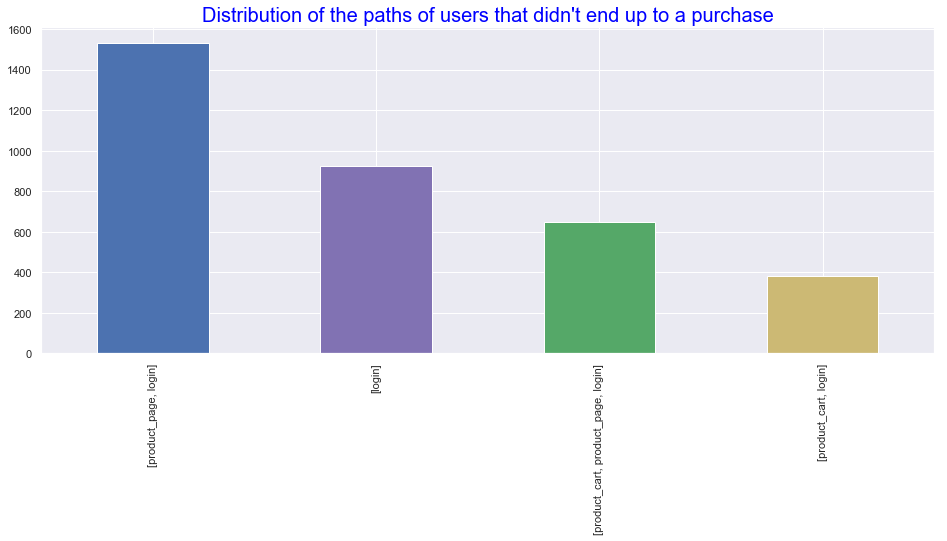

In [37]:
user_path['event_name'].value_counts().plot(kind='bar',figsize=(16,6),color={'b','y','g','m'})
plt.title("Distribution of the paths of users that didn't end up to a purchase",fontsize=20,color='blue')
plt.show()

* The path [product_cart,login] could be related to a technical issue of the page(didn't record the product_page step or the user let the product in the cart and left, and when returned, went directly to the product_cart page.
* Or that an event doesn't equal a user. One person can add several items to the cart.

Total number of purchases of Group A:2430
Total number of purchases of Group B:649
Total unique users of Group A:2604
Total unique users of Group B:877


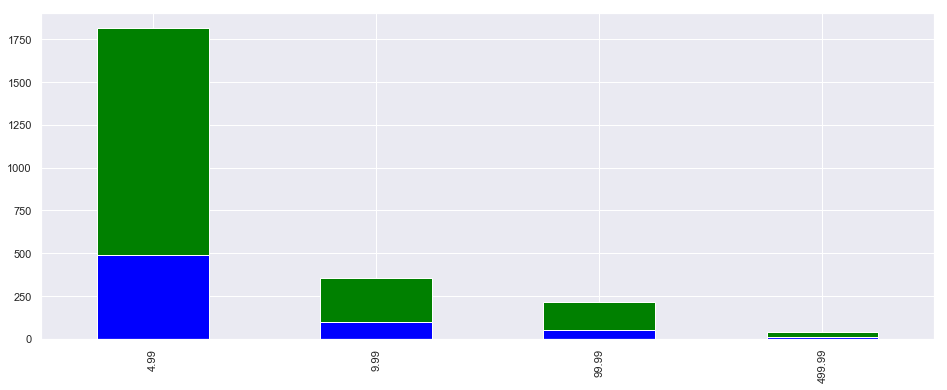

In [38]:
print(colored('Total number of purchases of Group A:{}'.format(final_recommender[(final_recommender['group']=='A') & \
                                           (final_recommender['event_name']=='purchase')]['details'].count()),\
             on_color='on_green'))
print(colored('Total number of purchases of Group B:{}'.format(final_recommender[(final_recommender['group']=='B') & \
                                           (final_recommender['event_name']=='purchase')]['details'].count()),\
             on_color='on_blue'))
print(colored('Total unique users of Group A:{}'\
      .format(final_recommender[final_recommender['group']=='A']['user_id'].nunique()),on_color='on_green'))
print(colored('Total unique users of Group B:{}'\
      .format(final_recommender[final_recommender['group']=='B']['user_id'].nunique()),on_color='on_green'))

final_recommender[final_recommender['group']=='A']['details'].value_counts()\
.plot(kind='bar',grid=True,color='green',figsize=(16,6))
final_recommender[final_recommender['group']=='B']['details'].value_counts()\
.plot(kind='bar',grid=True,color='blue',figsize=(16,6))
plt.show()

* Most frequent amount purchase is 4.99, and the range of the cost of the products/services is shared in 4 levels
* Group A have ended up to much more purchases

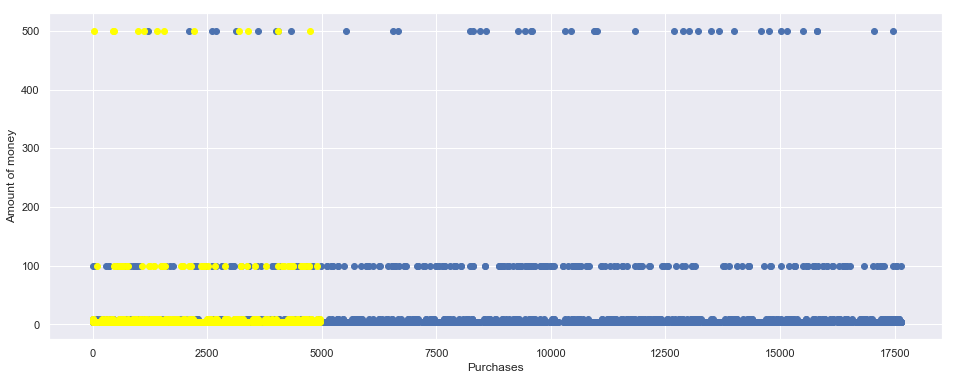

54 purchases are close to 500$ out of 3079 total number of purchases
Where 42 purchases come from Group A and 12 from Group B


In [39]:
# check behaviour of purchases for anomalies
fig,ax=plt.subplots(figsize=(16,6))
plt.scatter(x=range(0,len(final_recommender[final_recommender['group']=='A'])),\
            y=final_recommender[final_recommender['group']=='A']['details'])
plt.scatter(x=range(0,len(final_recommender[final_recommender['group']=='B'])),\
            y=final_recommender[final_recommender['group']=='B']['details'],color='yellow')
plt.xlabel('Purchases')
plt.ylabel('Amount of money')
plt.show()
print(colored('{} purchases are close to 500$ out of {} total number of purchases'\
      .format(len(final_recommender[final_recommender['details']>100]),\
             final_recommender[final_recommender['event_name']=='purchase']['details'].count()),on_color='on_yellow'))
print(colored('Where {} purchases come from Group A and {} from Group B'\
              .format(len(final_recommender[(final_recommender['group']=='A')\
                                            & (final_recommender['details']>100)]),\
                     len(final_recommender[(final_recommender['group']=='B')\
                                            & (final_recommender['details']>100)])),on_color='on_blue'))

* How many users did more than 1 purchase

In [40]:
user_purchases=final_recommender.groupby(['user_id','group'],as_index=False)\
.agg({'details':'count'}).sort_values('details',ascending=False)
print('{} users have done more than one purchase.'\
      .format(int(user_purchases[user_purchases['details']>1]['details'].count())))
print('With participation to each group :')
print(user_purchases[user_purchases['details']>1]['group'].value_counts())

954 users have done more than one purchase.
With participation to each group :
A    754
B    200
Name: group, dtype: int64


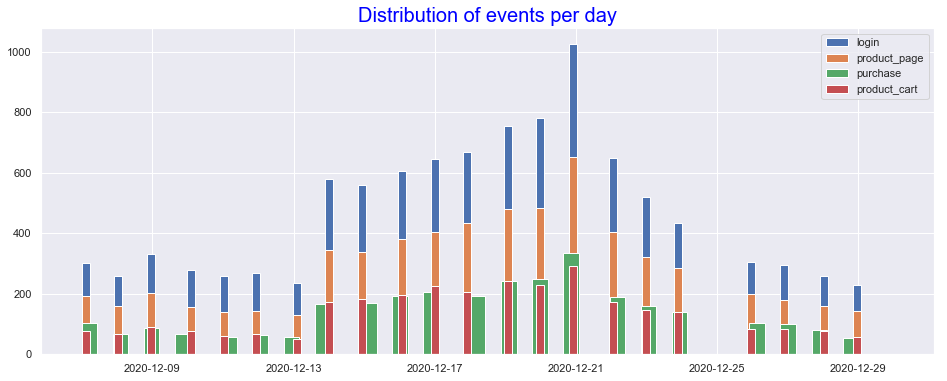

In [41]:
final_recommender[final_recommender['event_name']=='login']['event_dt_date']\
.hist(bins=100,figsize=(16,6),label='login')
final_recommender[final_recommender['event_name']=='product_page']['event_dt_date']\
.hist(bins=100,figsize=(16,6),label='product_page')
final_recommender[final_recommender['event_name']=='purchase']['event_dt_date']\
.hist(bins=50,figsize=(16,6),label='purchase')
final_recommender[final_recommender['event_name']=='product_cart']['event_dt_date']\
.hist(bins=100,figsize=(16,6),label='product_cart')
plt.title('Distribution of events per day',fontsize=20,color='blue')
plt.legend()
plt.show()

* We observe higher activity between the 2020-12-13 and 2020-12-21. Is before Christmas time. People are more motivated to spend those days

In [42]:
#per day the number of users, the number of buys and the mean daily amount of purchases
daily_users_buys=final_recommender.groupby('event_dt_date',as_index=False)\
.agg({'user_id':'nunique','details':['count','mean']})\
.rename(columns={'user_id':'number_users','nunique':'number_purchases','mean':'mean_daily_purchase'})\
.reset_index(drop=True)
daily_users_buys.columns=['date','number_users','number_purchases','mean_daily_purchase']
display(daily_users_buys.head())
print(colored('DAU : daily active users {:.2f}'.format(daily_users_buys['number_users'].mean()),on_color='on_yellow'))

,date,number_users,number_purchases,mean_daily_purchase
0,2020-12-07,311,102,17.735098
1,2020-12-08,261,66,18.777879
2,2020-12-09,332,86,13.652791
3,2020-12-10,280,68,21.313529
4,2020-12-11,260,56,21.150714


DAU : daily active users 446.57


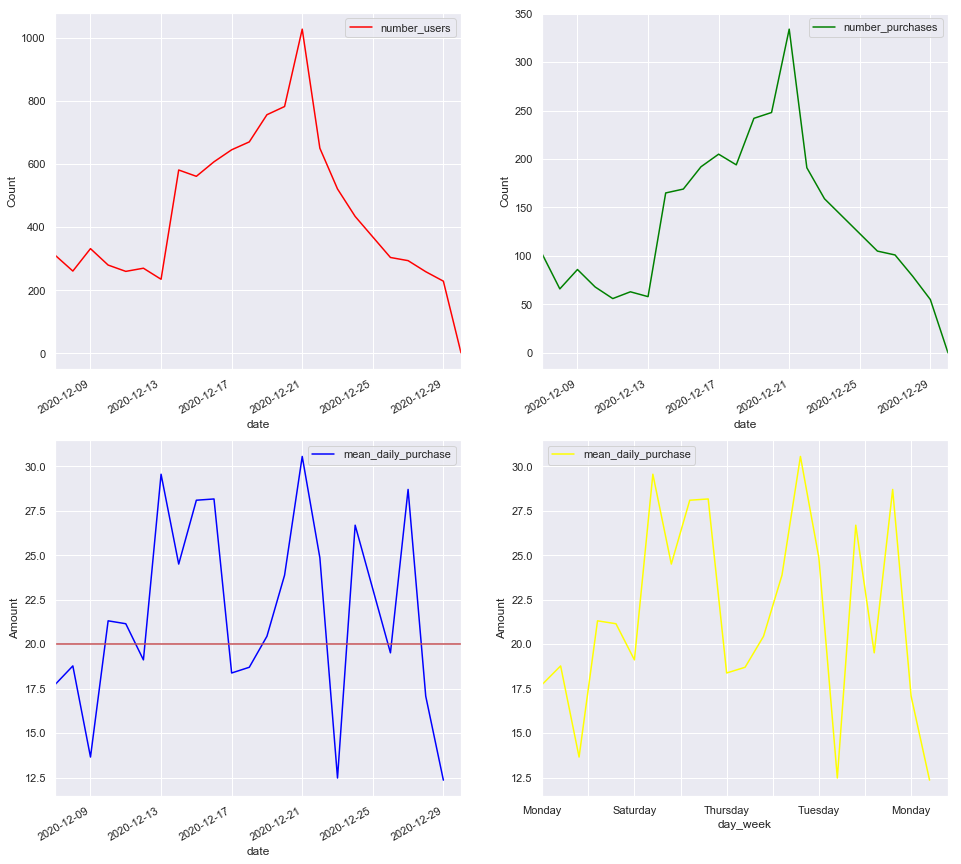

In [43]:
fig,axes=plt.subplots(2,2,figsize=(16,16))

daily_users_buys.plot(x='date',y='number_users',ax=axes[0,0],color='red')
daily_users_buys.plot(x='date',y='number_purchases',ax=axes[0,1],color='green')
daily_users_buys.plot(x='date',y='mean_daily_purchase',ax=axes[1,0],color='blue')

#check the days of the week
daily_users_buys_2=daily_users_buys
daily_users_buys_2['day_week']=daily_users_buys_2['date'].dt.day_name()
daily_users_buys_2.plot(x='day_week',y='mean_daily_purchase',ax=axes[1,1],color='yellow')
axes[1,0].axhline(y=20, color='r', linestyle='-')
axes[0,0].set_ylabel('Count')
axes[0,1].set_ylabel('Count')
axes[1,0].set_ylabel('Amount')
axes[1,1].set_ylabel('Amount')
plt.show()

* We see that 22-23 of December there is a drop in mean amount of purchases while the number of users and of number of purchases growing up constantly from 13 of December till 21.

- Study conversion at different funnel stages

In [44]:
#Check sample sizes
print('Size sample for Group A:', final_recommender[final_recommender['group']=='A'].shape[0])
print('Size sample for Group B:', final_recommender[final_recommender['group']=='B'].shape[0])

Size sample for Group A: 17670
Size sample for Group B: 5004


In [45]:
print(colored('Static funnel of stages',on_color='on_red'))
print('Group A funnel stages:','\n',final_recommender[final_recommender['group']=='A']\
      .groupby('event_name').agg({'user_id':'nunique'}))
print('')
print('Group B funnel stages:','\n',final_recommender[final_recommender['group']=='B']\
      .groupby('event_name').agg({'user_id':'nunique'}))



Static funnel of stages
Group A funnel stages: 
               user_id
event_name           
login            2604
product_cart      782
product_page     1685
purchase          833

Group B funnel stages: 
               user_id
event_name           
login             876
product_cart      244
product_page      493
purchase          249


In [46]:
print(colored('Conversion of visits funnel for each stage of Group A',on_color='on_yellow'))
final_recommender[final_recommender['group']=='A'].groupby('event_name')\
.agg({'user_id':'nunique'})/final_recommender[final_recommender['group']=='A']['user_id'].nunique()

Conversion of visits funnel for each stage of Group A


,user_id
event_name,
login,1.000000
product_cart,0.300307
product_page,0.647081
purchase,0.319892


In [47]:
print(colored('Conversion of visits funnel for each stage of Group B',on_color='on_yellow'))
final_recommender[final_recommender['group']=='B'].groupby('event_name')\
.agg({'user_id':'nunique'})/final_recommender[final_recommender['group']=='B']['user_id'].nunique()

Conversion of visits funnel for each stage of Group B


,user_id
event_name,
login,0.998860
product_cart,0.278221
product_page,0.562144
purchase,0.283922


In [57]:
#plot the event funnels of each group
dfA=final_recommender[final_recommender['group']=='A'].groupby('event_name')\
.agg({'user_id':'nunique'})/final_recommender[final_recommender['group']=='A']\
['user_id'].nunique()

dfB=final_recommender[final_recommender['group']=='B'].groupby('event_name')\
.agg({'user_id':'nunique'})/final_recommender[final_recommender['group']=='B']\
['user_id'].nunique()


fig = go.Figure()

fig.add_trace(go.Funnel(
    name = 'GroupA',
    y = dfA.index,
    x = dfA['user_id'],
    textinfo = "value+percent initial+percent previous"))

fig.add_trace(go.Funnel(
    name = 'GroupB',
    y = dfB.index,
    x = dfB['user_id'],
    textinfo = "value+percent initial+percent previous"))

fig.update_layout(
    title={ 'text': "The event funnel",
            'y':0.9, 'x':0.4,
            'xanchor': 'left',
            'yanchor': 'top'},
)


fig.show()

In [804]:
final_recommender[final_recommender['ab_test']=='recommender_system_test']['group'].value_counts(normalize=True)

A    0.779307
B    0.220693
Name: group, dtype: float64

* Group B has a 4% difference in the purchase conversion rate with Group B but Group A is 3 times bigger

- Is the number of events per user distributed equally in the samples?

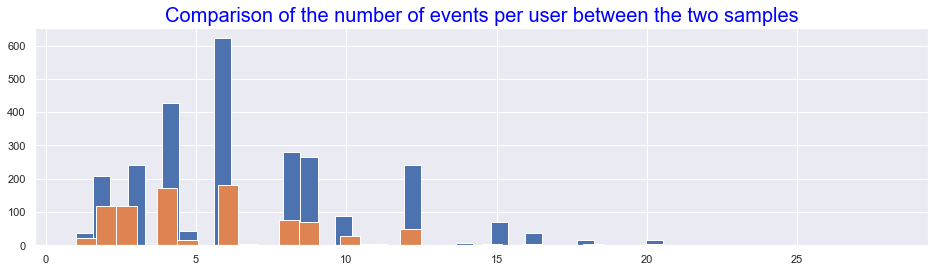

In [805]:
final_recommender[final_recommender['group']=='A'].groupby('user_id')['event_name']\
.count().hist(bins=40,figsize=(16,4))
final_recommender[final_recommender['group']=='B'].groupby('user_id')['event_name']\
.count().hist(bins=40,figsize=(16,4))
plt.title('Comparison of the number of events per user between the two samples',fontsize=20,color='blue')
plt.show()

* The number of events per user is not distributed equally in the samples.

- Are there users who enter both samples?

In [806]:
mutual=set(final_recommender[final_recommender['group']=='A']['user_id'])\
.intersection(set(final_recommender[final_recommender['group']=='B']['user_id']))
mutual

set()

* No shared users between groups

In [807]:
final_recommender[final_recommender['group']=='A'].groupby('user_id',as_index=False)['event_name'].count().shape[0]

2604

- How is the number of events distributed by days?

In [808]:
final_recommender.head(2)

,user_id,group,ab_test,region,device,sign_date,event_dt,event_name,details,event_dt_date,first_date_buy
0,D1ABA3E2887B6A73,A,recommender_system_test,EU,PC,2020-12-07,2020-12-07 14:43:27,purchase,99.99,2020-12-07,2020-12-07 14:43:27
1,D1ABA3E2887B6A73,A,recommender_system_test,EU,PC,2020-12-07,2020-12-07 14:43:29,product_cart,NaN,2020-12-07,2020-12-07 14:43:27


In [809]:
events_distributed_by_days.columns

Index(['number_of_events'], dtype='object')

In [810]:
events_distributed_by_days=final_recommender.groupby('event_dt_date')\
    .agg({'event_name':'value_counts'}).rename(columns={'event_name':'number_of_events'})#.plot(kind='bar')
events_distributed_by_days.head()

number_of_events
event_dt_date event_name                    
2020-12-07    login                      303
              product_page               193
              purchase                   102
              product_cart                76
2020-12-08    login                      259

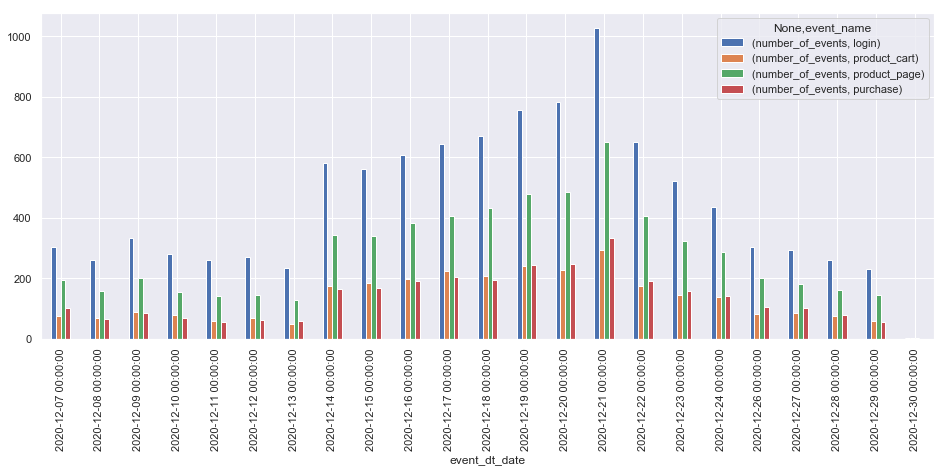

In [811]:
events_distributed_by_days.unstack().plot(kind='bar',figsize=(16,6))
plt.show()

* we see an increase of login event on 2020-12-14 that keep on going up again after 2020-12-16 till 2020-12-21

- Think of the possible details in the data that you have to take into account before starting the A/B test?
> * Splitting test traffic correctly
> * The peeking problem by moving out the outliers of cumulative graphs 
> * The sample size
> * Running time of the test
> * Correct statistical significance if we have multiple comparisons we the same data

- Evaluate the A/B test results
    - What can you tell about the A/B test results?
    - Use the z-criterion to check the statistical difference between the proportions

In [812]:
final_recommender.head()

,user_id,group,ab_test,region,device,sign_date,event_dt,event_name,details,event_dt_date,first_date_buy
0,D1ABA3E2887B6A73,A,recommender_system_test,EU,PC,2020-12-07,2020-12-07 14:43:27,purchase,99.99,2020-12-07,2020-12-07 14:43:27
1,D1ABA3E2887B6A73,A,recommender_system_test,EU,PC,2020-12-07,2020-12-07 14:43:29,product_cart,NaN,2020-12-07,2020-12-07 14:43:27
2,D1ABA3E2887B6A73,A,recommender_system_test,EU,PC,2020-12-07,2020-12-07 14:43:27,product_page,NaN,2020-12-07,2020-12-07 14:43:27
3,D1ABA3E2887B6A73,A,recommender_system_test,EU,PC,2020-12-07,2020-12-07 14:43:27,login,NaN,2020-12-07,2020-12-07 14:43:27
4,A7A3664BD6242119,A,recommender_system_test,EU,iPhone,2020-12-20,2020-12-20 15:46:06,product_page,NaN,2020-12-20,NaN


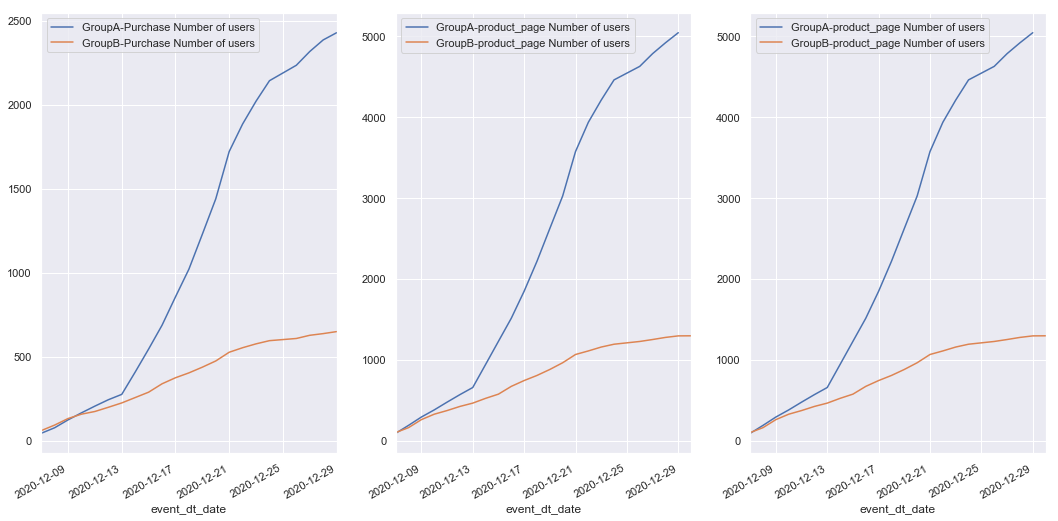

In [816]:
#visualise the cumulative daily conversion for each event,for each Group
#for purchase event
purchase_convA=final_recommender[(final_recommender['group']=='A') \
                              & (final_recommender['event_name']=='purchase')].groupby('event_dt_date')\
.agg({'user_id':'nunique'}).rename(columns={'user_id':'number_users'})

#for product_page
product_page_convA=final_recommender[(final_recommender['group']=='A') \
                              & (final_recommender['event_name']=='product_page')].groupby('event_dt_date')\
.agg({'user_id':'nunique'}).rename(columns={'user_id':'number_users'})
#for product_cart
product_cart_convA=final_recommender[(final_recommender['group']=='A') \
                              & (final_recommender['event_name']=='product_cart')].groupby('event_dt_date')\
.agg({'user_id':'nunique'}).rename(columns={'user_id':'number_users'})

#Get the cumulative daily conversion
cum_purchase_convA=purchase_convA.cumsum()
cum_product_page_convA=product_page_convA.cumsum()
cum_product_cart_convA=product_cart_convA.cumsum()

#=======================================================#

#do the same for GroupB
purchase_convB=final_recommender[(final_recommender['group']=='B') \
                              & (final_recommender['event_name']=='purchase')].groupby('event_dt_date')\
.agg({'user_id':'nunique'}).rename(columns={'user_id':'number_users'})

#for product_page
product_page_convB=final_recommender[(final_recommender['group']=='B') \
                              & (final_recommender['event_name']=='product_page')].groupby('event_dt_date')\
.agg({'user_id':'nunique'}).rename(columns={'user_id':'number_users'})
#for product_cart
product_cart_convB=final_recommender[(final_recommender['group']=='B') \
                              & (final_recommender['event_name']=='product_cart')].groupby('event_dt_date')\
.agg({'user_id':'nunique'}).rename(columns={'user_id':'number_users'})

#Get the cumulative daily conversion
cum_purchase_convB=purchase_convB.cumsum()
cum_product_page_convB=product_page_convB.cumsum()
cum_product_cart_convB=product_cart_convB.cumsum()

#Plot the cumulative daily conversions
fig,axes=plt.subplots(1,3,figsize=(18,9))
cum_purchase_convA.plot(ax=axes[0])
cum_purchase_convB.plot(ax=axes[0])
axes[0].legend(['GroupA-Purchase Number of users','GroupB-Purchase Number of users'])

cum_product_page_convA.plot(ax=axes[1])
cum_product_page_convB.plot(ax=axes[1])
axes[1].legend(['GroupA-product_page Number of users','GroupB-product_page Number of users'])

cum_product_page_convA.plot(ax=axes[2])
cum_product_page_convB.plot(ax=axes[2])
axes[2].legend(['GroupA-product_page Number of users','GroupB-product_page Number of users'])

plt.show()

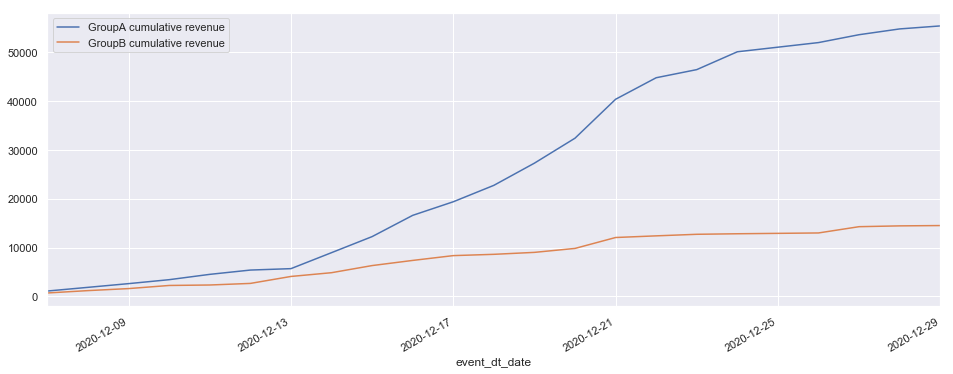

In [817]:
revenue_convA=final_recommender[(final_recommender['group']=='A') \
                              & (final_recommender['event_name']=='purchase')].groupby('event_dt_date')\
.agg({'details':'sum'}).rename(columns={'details':'revenue'})


revenue_convB=final_recommender[(final_recommender['group']=='B') \
                              & (final_recommender['event_name']=='purchase')].groupby('event_dt_date')\
.agg({'details':'sum'}).rename(columns={'details':'revenue'})

cum_revenue_convA=revenue_convA.cumsum()
cum_revenue_convB=revenue_convB.cumsum()

fig,ax=plt.subplots(figsize=(16,6))
cum_revenue_convA.plot(ax=ax)
cum_revenue_convB.plot(ax=ax)
plt.legend(['GroupA cumulative revenue','GroupB cumulative revenue'])
plt.show()

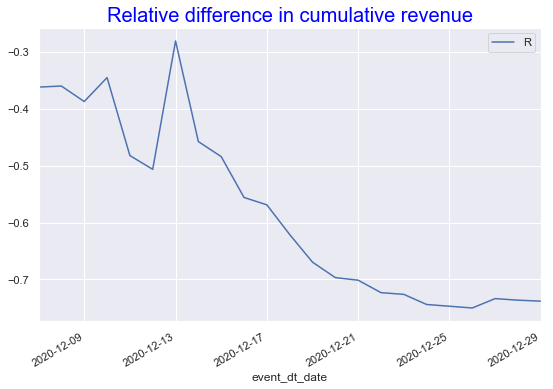

In [821]:
#plot the relative difference for purchase cumulative conversion
((cum_revenue_convB/cum_revenue_convA)-1).plot(figsize=(9,6),label=True)
plt.title('Relative difference in cumulative revenue',fontsize=20,color='blue')
plt.legend('Relative')
plt.show()


- In every event GroupA has better converion and the difference in getting greater as we heading to the end of the test.
- An explaination could be the already big difference in the sample of Group A while to the fact user's traffic come from difference devices as mobile android where you can use it remotely and on the way during the period of Christmas that the AB test was conducted and is common for people this period to use their desktops (PC) much less.
- After 13 of December is clear that the relative direfence is growing up constantly 

- Find the statistical significance of the difference in conversion between the groups 

In [870]:
#Create sampleA and sampleB to find the statistical significance in conversion first for the  purchase event 
#each sample will be constructed by the number of purchases or NO purchase of each user
A_buyers=final_recommender[(final_recommender['group']=='A')\
                  & (final_recommender['event_name']=='purchase')]\
.groupby('user_id',as_index=False).agg({'event_name':'count'}).rename(columns={'event_name':'n_buys'})
B_buyers=final_recommender[(final_recommender['group']=='B')\
                  & (final_recommender['event_name']=='purchase')]\
.groupby('user_id',as_index=False).agg({'event_name':'count'}).rename(columns={'event_name':'n_buys'})

#find the users that made none purchase
A_no_buyers=final_recommender[(final_recommender['group']=='A')\
                  & (final_recommender['event_name']!='purchase')]['user_id'].unique()
B_no_buyers=final_recommender[(final_recommender['group']=='B')\
                  & (final_recommender['event_name']!='purchase')]['user_id'].unique()

#create a dataframe with the user_id and 0 values since is for the users that never ended to a purchase
#for groupA
A_no_buyers_df=pd.DataFrame(A_no_buyers,columns={'user_id'})
A_no_buyers_df['n_buys']=pd.Series(0,range(len(A_no_buyers_df)))
#for groupB
B_no_buyers_df=pd.DataFrame(B_no_buyers,columns={'user_id'})
B_no_buyers_df['n_buys']=pd.Series(0,range(len(B_no_buyers_df)))

#Get the samples(the series) with the purchases for values
sampleA=pd.concat([A_buyers,A_no_buyers_df],axis=0).reset_index(drop=True)['n_buys']
sampleB=pd.concat([A_buyers,B_no_buyers_df],axis=0).reset_index(drop=True)['n_buys']

* By formulating a null hypothesis this could be:
> - Ho:The difference of the mean of the two samples has no statistical significance
> - H1:Alternative hypothesis would be their difference is statistical significant 

In [874]:
#checking the normality of our samples
alpha = .05 # significance level

results = st.shapiro(sampleA)
p_value = results[1] # the second value in the array of results (with index 1) - the p-value

print('p-value: ', p_value)

if (p_value < alpha):
    print("Null hypothesis rejected: the distribution is not normal")
else:
    print("Failed to reject the null hypothesis: the distribution seems to be normal") 

p-value:  0.0
Null hypothesis rejected: the distribution is not normal


In [875]:
alpha = .05 # significance level

results = st.shapiro(sampleB)
p_value = results[1] # the second value in the array of results (with index 1) - the p-value

print('p-value: ', p_value)

if (p_value < alpha):
    print("Null hypothesis rejected: the distribution is not normal")
else:
    print("Failed to reject the null hypothesis: the distribution seems to be normal") 

p-value:  3.915227909323539e-42
Null hypothesis rejected: the distribution is not normal


Since the sample's distribution is not normal we will run our test with a non-parametric test. The MannWhitney

In [876]:
alpha = .05 #significance level

results = st.mannwhitneyu(sampleA, sampleB)

print('p-value: ', results.pvalue)

if (results.pvalue < alpha):
    print("Null hypothesis rejected: the difference is statistically significant")
else:
    print("Failed to reject the null hypothesis: we can't make conclusions about the difference") 

p-value:  3.3085854374368126e-67
Null hypothesis rejected: the difference is statistically significant


- We will check if we can draw a conclusion about the difference between the purchases / login conversion rates,by using the z-criterion to check the statistical difference between these proportions for GroupA,B


In [884]:
purchasesA=sampleA.sum()
purchasesB=sampleB.sum()
loginA=final_recommender[(final_recommender['group']=='A') & (final_recommender['event_name']=='login')].shape[0]
loginB=final_recommender[(final_recommender['group']=='B') & (final_recommender['event_name']=='login')].shape[0]


alpha = .05 # significance level

purchasesAB = np.array([purchasesA, purchasesB])
loginAB = np.array([loginA, loginB])

# success proportion in the first group:
p1 = purchasesAB[0]/loginAB[0]

# success proportion in the second group:
p2 = purchasesAB[1]/loginAB[1]

# success proportion in the combined dataset:
p_combined = (purchasesAB[0] + purchasesAB[1]) / (loginAB[0] + loginAB[1])

# the difference between the datasets' proportions
difference = p1 - p2 

In [885]:
# calculating the statistic in standard deviations of the standard normal distribution
z_value = difference / mth.sqrt(p_combined * (1 - p_combined) * (1/loginAB[0] + 1/loginAB[1]))

# setting up the standard normal distribution (mean 0, standard deviation 1)
distr = st.norm(0, 1)  

In [886]:
# calculating the statistic in standard deviations of the standard normal distribution
z_value = difference / mth.sqrt(p_combined * (1 - p_combined) * (1/loginAB[0] + 1/loginAB[1]))

# setting up the standard normal distribution (mean 0, standard deviation 1)
distr = st.norm(0, 1) 

p_value = (1 - distr.cdf(abs(z_value))) * 2

print('p-value: ', p_value)

if (p_value < alpha):
    print("Rejecting the null hypothesis: there is a significant difference between the proportions")
else:
    print("Failed to reject the null hypothesis: there is no reason to consider the proportions different") 

p-value:  0.0
Rejecting the null hypothesis: there is a significant difference between the proportions


- Conclusions on the EDA stage, as well as on the evaluation of the A/B test results:

> - In every event GroupA has better converion and the difference is getting greater as we heading to the end of the test.
An explaination could be the already big difference in the sample of Group A while to the fact that users traffic come from difference devices like mobile android where you can use it remotely and on the way during the period of Christmas where the AB test was conducted and is common for people this period to use their desktops (PC) much less.
After 13th of December is clear that the relative direfence is growing up constantly

> - The splitting of the test traffic was not correct.
- The peeking problem by moving out the outliers or plot cumulative graphs didn't help
- The sample size was not correct
- Running time of the test was not correct since we would like within 14 days of signing up, users to show better conversion , but for the users that signed up the last day of registration there was only 7 days forward time-period.
- According to the https://www.evanmiller.org/ab-testing/sample-size.html calculator of sample size, the sample should have had a size of 337 but here is much bigger.(keeping in mind that the current conversion was about 30% and the detectable effect 10%.
> - Group B has a 4% difference,less, in the purchase conversion rate with Group B but Group A is 3 times bigger
> - We saw that 22-23 of December there is a drop in mean amount of purchases while the number of users and of number of purchases growing up constantly from 13 of December till 21.It Is before Christmas time. People are more motivated to spend those days, hence after numbers go down in every event stage. The test might be better to have been executed another period, maybe after christmas where could be eventually more stable parameters that could influence the users behaviour.

> - None of the tests fulfill the standars of the description,beginning with the sample sizes that are not equally splitted.
We chose the recommender_system_test cause it was closer to the test participants and has much smaller sample size.The participants should be around 6000 according to the description and the recommender_system_test had this number closer for the test group. Since there are strong evidences that the test will fail due to the wrong preparation , with the recommender_system_test at least we will sacrifice less users. 
Futhermore, since there is no balance between the traffic devices, we didn't filter the data for the same device between the users of both groups but we will work with all of them.
-Generally we can say that the AB test didn't gave any fertile output to take it into consideration and it might should be executed again but we more careful and precise preparation.